In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna # 하이퍼파라미터 튜닝 라이브러리
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Optuna
하이퍼파라미터 최적화 태스크를 도와주는 프레임워크로 파라미터 범위나 목록을 설정하면 매 trial마다 파라미터를 변경하며 최적 파라미터를 찾습니다.

In [2]:
df = pd.read_csv("../input/30days-folds/train_folds.csv")
df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

useful_features = [c for c in df.columns if c not in ("id", "target", "kfold")]
object_cols = [col for col in useful_features if col.startswith("cat")]
df_test = df_test[useful_features]

for col in object_cols:
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)
        
        # 명목형 변수를 그냥 라벨 처리하기에는 한계가 있으므로 각 값 별로 타겟값의 평균을 대입해주고자 한다.
        # 이때 과적합을 막기위해 5-foldCV를 활용하여 각 폴드별 값의 평균을 대입해준다.
        feat = xtrain.groupby(col)["target"].agg("mean")
        feat = feat.to_dict()
        xvalid.loc[:, f"tar_enc_{col}"] = xvalid[col].map(feat)
        temp_df.append(xvalid)
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    
    temp_test_feat /= 5
    df_test.loc[:, f"tar_enc_{col}"] = temp_test_feat
    df = pd.concat(temp_df)
    

useful_features = [c for c in df.columns if c not in ("id", "target", "kfold")]
object_cols = [col for col in useful_features if col.startswith("cat")]
df_test = df_test[useful_features]

In [3]:
def run(trial):
    # 구하고자하는 변수들의 범위 설정
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)

    ytrain = xtrain.target
    yvalid = xvalid.target

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    # 앞에서 명목형 변수들에 대하여 새로운 변수를 만들었으므로 기존 변수는 라벨인코딩하여 적용
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])

    model = XGBRegressor(
        random_state=42,
        # XGB GPU활용 파라미터
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False) # 평가지표 설정
    return rmse

In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=20)

[I 2021-08-31 13:56:52,858] A new study created in memory with name: no-name-1ea37b47-7d17-4c38-a151-20ebfc4d9fb4


[13:56:55] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.45348
[1000]	validation_0-rmse:0.72546
[2000]	validation_0-rmse:0.72268
[3000]	validation_0-rmse:0.72153
[4000]	validation_0-rmse:0.72099
[4224]	validation_0-rmse:0.72095


[I 2021-08-31 13:57:04,755] Trial 0 finished with value: 0.7208663569543977 and parameters: {'learning_rate': 0.04236645755747465, 'reg_lambda': 0.00017917203059312773, 'reg_alpha': 1.9677011989167023e-08, 'subsample': 0.11723470587372208, 'colsample_bytree': 0.31884120411595696, 'max_depth': 2}. Best is trial 0 with value: 0.7208663569543977.


[13:57:07] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.65176
[1000]	validation_0-rmse:0.72326
[1387]	validation_0-rmse:0.72323


[I 2021-08-31 13:57:31,262] Trial 1 finished with value: 0.7231244390394342 and parameters: {'learning_rate': 0.01666262200030407, 'reg_lambda': 0.004799115482873595, 'reg_alpha': 2.2293549123341754e-08, 'subsample': 0.25511024160377876, 'colsample_bytree': 0.9809448893203835, 'max_depth': 8}. Best is trial 0 with value: 0.7208663569543977.


[13:57:33] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.65895
[1000]	validation_0-rmse:0.72221
[2000]	validation_0-rmse:0.72033
[2650]	validation_0-rmse:0.72027


[I 2021-08-31 13:58:02,953] Trial 2 finished with value: 0.7201980723847692 and parameters: {'learning_rate': 0.015690549342141036, 'reg_lambda': 20.454943979611322, 'reg_alpha': 0.0010907031912967043, 'subsample': 0.9099075003400349, 'colsample_bytree': 0.9432973167525017, 'max_depth': 7}. Best is trial 2 with value: 0.7201980723847692.


[13:58:05] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.61302
[1000]	validation_0-rmse:0.71984
[2000]	validation_0-rmse:0.71922
[2230]	validation_0-rmse:0.71932


[I 2021-08-31 13:58:27,576] Trial 3 finished with value: 0.7191597711719623 and parameters: {'learning_rate': 0.021655402693982542, 'reg_lambda': 1.1037761903685856e-05, 'reg_alpha': 0.009103102247118067, 'subsample': 0.744947973920315, 'colsample_bytree': 0.267133103460835, 'max_depth': 7}. Best is trial 3 with value: 0.7191597711719623.


[13:58:29] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.15159
[558]	validation_0-rmse:0.72477


[I 2021-08-31 13:58:36,276] Trial 4 finished with value: 0.7232188407784418 and parameters: {'learning_rate': 0.08174112923181484, 'reg_lambda': 2.6967114127585323e-08, 'reg_alpha': 3.031743397276524e-05, 'subsample': 0.7653856524475829, 'colsample_bytree': 0.9478156952102259, 'max_depth': 7}. Best is trial 3 with value: 0.7191597711719623.


[13:58:38] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.54138
[1000]	validation_0-rmse:0.73261
[2000]	validation_0-rmse:0.72991
[3000]	validation_0-rmse:0.72841
[4000]	validation_0-rmse:0.72726
[5000]	validation_0-rmse:0.72641
[6000]	validation_0-rmse:0.72567
[6999]	validation_0-rmse:0.72504


[I 2021-08-31 13:58:52,098] Trial 5 finished with value: 0.7250442054922013 and parameters: {'learning_rate': 0.03095388883730026, 'reg_lambda': 0.8087491162293724, 'reg_alpha': 0.0040022401087799015, 'subsample': 0.3573726085768172, 'colsample_bytree': 0.9774280492456515, 'max_depth': 1}. Best is trial 3 with value: 0.7191597711719623.


[13:58:54] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.50678
[687]	validation_0-rmse:0.72551


[I 2021-08-31 13:59:24,639] Trial 6 finished with value: 0.7243679628023074 and parameters: {'learning_rate': 0.035523718045623764, 'reg_lambda': 0.189456803990362, 'reg_alpha': 0.3633345813155884, 'subsample': 0.4795916638646497, 'colsample_bytree': 0.5498515508889393, 'max_depth': 10}. Best is trial 3 with value: 0.7191597711719623.


[13:59:27] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.57840
[1000]	validation_0-rmse:0.72474
[1212]	validation_0-rmse:0.72508


[I 2021-08-31 13:59:34,918] Trial 7 finished with value: 0.7245416243941109 and parameters: {'learning_rate': 0.02622253171192878, 'reg_lambda': 0.0001274031167846888, 'reg_alpha': 0.0007749936927450965, 'subsample': 0.1320496035512498, 'colsample_bytree': 0.9756134236755468, 'max_depth': 6}. Best is trial 3 with value: 0.7191597711719623.


[13:59:37] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.37754
[1000]	validation_0-rmse:0.72148
[2000]	validation_0-rmse:0.71972
[2704]	validation_0-rmse:0.71950


[I 2021-08-31 13:59:44,715] Trial 8 finished with value: 0.7194856549039716 and parameters: {'learning_rate': 0.052346574162136277, 'reg_lambda': 0.00020849991912874852, 'reg_alpha': 1.759296991053808e-07, 'subsample': 0.443325906966082, 'colsample_bytree': 0.6251767750481337, 'max_depth': 3}. Best is trial 3 with value: 0.7191597711719623.


[13:59:47] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.79002
[1000]	validation_0-rmse:0.72062
[1135]	validation_0-rmse:0.72049


[I 2021-08-31 13:59:53,539] Trial 9 finished with value: 0.7204674298300009 and parameters: {'learning_rate': 0.12857694073814177, 'reg_lambda': 0.05085054900824138, 'reg_alpha': 67.79105602887392, 'subsample': 0.29314203558778107, 'colsample_bytree': 0.19003888986982156, 'max_depth': 7}. Best is trial 3 with value: 0.7191597711719623.


[13:59:55] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.07157
[785]	validation_0-rmse:0.71964


[I 2021-08-31 13:59:58,646] Trial 10 finished with value: 0.7190484827272379 and parameters: {'learning_rate': 0.22197079793631685, 'reg_lambda': 2.42533526696198e-07, 'reg_alpha': 3.6898094356806146, 'subsample': 0.6685232071697209, 'colsample_bytree': 0.10524679082485311, 'max_depth': 4}. Best is trial 10 with value: 0.7190484827272379.


[14:00:01] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:5.87746
[620]	validation_0-rmse:0.71938


[I 2021-08-31 14:00:03,468] Trial 11 finished with value: 0.7190495979545202 and parameters: {'learning_rate': 0.24724745008454518, 'reg_lambda': 4.192964874210161e-07, 'reg_alpha': 8.666560967659336, 'subsample': 0.6762775504536049, 'colsample_bytree': 0.13466290612432774, 'max_depth': 4}. Best is trial 10 with value: 0.7190484827272379.


[14:00:05] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.21540
[1000]	validation_0-rmse:0.71847
[1839]	validation_0-rmse:0.71821


[I 2021-08-31 14:00:12,333] Trial 12 finished with value: 0.718141388570632 and parameters: {'learning_rate': 0.20325554738203383, 'reg_lambda': 1.1725779816973637e-08, 'reg_alpha': 74.77501662802612, 'subsample': 0.6508853215535669, 'colsample_bytree': 0.1120707377926681, 'max_depth': 4}. Best is trial 12 with value: 0.718141388570632.


[14:00:14] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:5.95584
[616]	validation_0-rmse:0.72244


[I 2021-08-31 14:00:17,057] Trial 13 finished with value: 0.720802115482823 and parameters: {'learning_rate': 0.23744992107819868, 'reg_lambda': 1.5248853254038918e-08, 'reg_alpha': 2.832156734251649, 'subsample': 0.6529143717933578, 'colsample_bytree': 0.42642219539766113, 'max_depth': 4}. Best is trial 12 with value: 0.718141388570632.


[14:00:19] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.56425
[1000]	validation_0-rmse:0.71767
[1423]	validation_0-rmse:0.71771


[I 2021-08-31 14:00:24,799] Trial 14 finished with value: 0.7175971967859089 and parameters: {'learning_rate': 0.15788724976061616, 'reg_lambda': 6.828061699571798e-07, 'reg_alpha': 40.019023406441164, 'subsample': 0.9879370976537889, 'colsample_bytree': 0.13153215892352968, 'max_depth': 4}. Best is trial 14 with value: 0.7175971967859089.


[14:00:27] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.68976
[975]	validation_0-rmse:0.71976


[I 2021-08-31 14:00:32,019] Trial 15 finished with value: 0.7195808976975706 and parameters: {'learning_rate': 0.14157412101126748, 'reg_lambda': 3.5894737083306974e-06, 'reg_alpha': 94.66678792390556, 'subsample': 0.9848393373050357, 'colsample_bytree': 0.777119895552179, 'max_depth': 5}. Best is trial 14 with value: 0.7175971967859089.


[14:00:34] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.62857
[1000]	validation_0-rmse:0.72791
[2000]	validation_0-rmse:0.72562
[3000]	validation_0-rmse:0.72431
[4000]	validation_0-rmse:0.72332
[5000]	validation_0-rmse:0.72259
[6000]	validation_0-rmse:0.72199
[6999]	validation_0-rmse:0.72146


[I 2021-08-31 14:00:49,333] Trial 16 finished with value: 0.721453118817149 and parameters: {'learning_rate': 0.14952126282024686, 'reg_lambda': 1.7546631837772703e-08, 'reg_alpha': 0.14526164185442977, 'subsample': 0.8814068757848001, 'colsample_bytree': 0.36341912697737566, 'max_depth': 1}. Best is trial 14 with value: 0.7175971967859089.


[14:00:52] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.00321
[1000]	validation_0-rmse:0.71937
[2000]	validation_0-rmse:0.71804
[3000]	validation_0-rmse:0.71781
[3268]	validation_0-rmse:0.71781


[I 2021-08-31 14:01:02,131] Trial 17 finished with value: 0.7177976880774679 and parameters: {'learning_rate': 0.10083707489717848, 'reg_lambda': 5.235582732301715e-07, 'reg_alpha': 55.8942018517784, 'subsample': 0.9805702681405516, 'colsample_bytree': 0.1812579541448145, 'max_depth': 3}. Best is trial 14 with value: 0.7175971967859089.


[14:01:04] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.17251
[1000]	validation_0-rmse:0.72341
[2000]	validation_0-rmse:0.72020
[3000]	validation_0-rmse:0.71886
[4000]	validation_0-rmse:0.71827
[5000]	validation_0-rmse:0.71803
[5719]	validation_0-rmse:0.71801


[I 2021-08-31 14:01:19,211] Trial 18 finished with value: 0.717994119322487 and parameters: {'learning_rate': 0.07884160928476121, 'reg_lambda': 1.0808732978156835e-06, 'reg_alpha': 1.4147253980812025e-05, 'subsample': 0.979771324564709, 'colsample_bytree': 0.21995871610794768, 'max_depth': 2}. Best is trial 14 with value: 0.7175971967859089.


[14:01:21] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.11783
[1000]	validation_0-rmse:0.72284
[2000]	validation_0-rmse:0.71975
[3000]	validation_0-rmse:0.71855
[4000]	validation_0-rmse:0.71821
[4573]	validation_0-rmse:0.71826


[I 2021-08-31 14:01:33,289] Trial 19 finished with value: 0.7181960881090187 and parameters: {'learning_rate': 0.08608916656665348, 'reg_lambda': 2.2395443091567016e-05, 'reg_alpha': 0.18594994527852826, 'subsample': 0.8510898314958293, 'colsample_bytree': 0.46618798516944265, 'max_depth': 2}. Best is trial 14 with value: 0.7175971967859089.


In [43]:
# 최종 하이퍼파라미터
study.best_params

{'learning_rate': 0.15788724976061616,
 'reg_lambda': 6.828061699571798e-07,
 'reg_alpha': 40.019023406441164,
 'subsample': 0.9879370976537889,
 'colsample_bytree': 0.13153215892352968,
 'max_depth': 4}

In [13]:
X = df.drop(['target', 'kfold', 'id'], axis=1)
y = df.target

In [14]:
ordinal_encoder = preprocessing.OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(X[object_cols])

In [158]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )


cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

-0.7233076192080196

optuna를 그냥 쓰면 여러 모델을 병렬적으로 쓰는 기능밖에 제시를 안 한다.
따라서 여러가지 옵션을 사용하여 파라미터를 찾아보자

## TPESampler
TPE(Tree-structured Parzen Estimator) 알고리즘을 사용하는 샘플러.
https://optuna.readthedocs.io/en/stable/reference/samplers.html

In [63]:
from optuna import Trial
from optuna.samplers import *

study = optuna.create_study(direction="minimize", sampler=TPESampler())
study.optimize(run, n_trials=20)

[14:32:58] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.24551
[1000]	validation_0-rmse:0.72984
[2000]	validation_0-rmse:0.72731
[3000]	validation_0-rmse:0.72592
[4000]	validation_0-rmse:0.72504
[5000]	validation_0-rmse:0.72426
[6000]	validation_0-rmse:0.72352
[6999]	validation_0-rmse:0.72298
[14:33:13] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.26263
[937]	validation_0-rmse:0.71987
[14:33:18] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.66986
[1000]	validation_0-rmse:0.72443
[2000]	validation_0-rmse:0.72112
[3000]	validation_0-rmse:0.71996
[4000]	validation_0-rmse:0.71961
[5000]	validation_0-rmse:0.71946
[5469]	validation_0-rmse:0.71947
[14:33:48] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.50502
[770]	validation_0-rmse:0.72390
[14:34:03] WARNING: ../src/

In [64]:
# 최종 하이퍼파라미터
study.best_params

{'learning_rate': 0.0893631011214955,
 'reg_lambda': 0.13723377322748506,
 'reg_alpha': 7.59392388796227,
 'subsample': 0.5255155155791094,
 'colsample_bytree': 0.1469616956634025,
 'max_depth': 3}

In [159]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

-0.7204223056463793

## SkoptSampler
Scikit-Optimize를 백엔드로 사용하는 샘플러.
https://optuna.readthedocs.io/en/stable/reference/integration.html

In [23]:
from optuna.integration import SkoptSampler

study = optuna.create_study(direction="minimize", sampler=SkoptSampler())
study.optimize(run, n_trials=20)

[I 2021-08-31 16:24:00,320] A new study created in memory with name: no-name-f93636c4-0acb-4257-8d8a-d415241fec7f


[16:24:02] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.38576
[563]	validation_0-rmse:0.72657


[I 2021-08-31 16:24:12,420] Trial 0 finished with value: 0.7252043379877546 and parameters: {'learning_rate': 0.051296917863167424, 'reg_lambda': 0.016927048956436683, 'reg_alpha': 0.0001797755056179272, 'subsample': 0.4051048005912111, 'colsample_bytree': 0.9423153796176481, 'max_depth': 8}. Best is trial 0 with value: 0.7252043379877546.


[16:24:14] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.61469
[1000]	validation_0-rmse:0.72932
[2000]	validation_0-rmse:0.72533
[3000]	validation_0-rmse:0.72308
[4000]	validation_0-rmse:0.72178
[5000]	validation_0-rmse:0.72094
[6000]	validation_0-rmse:0.72025
[6999]	validation_0-rmse:0.71983


[I 2021-08-31 16:24:30,144] Trial 1 finished with value: 0.7198316807515841 and parameters: {'learning_rate': 0.02144002119100468, 'reg_lambda': 6.559930205718348, 'reg_alpha': 0.6486812632959775, 'subsample': 0.31728279253192015, 'colsample_bytree': 0.5670875047397128, 'max_depth': 2}. Best is trial 1 with value: 0.7198316807515841.


[16:24:32] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:5.95302
[1000]	validation_0-rmse:0.71908
[2000]	validation_0-rmse:0.71822
[2154]	validation_0-rmse:0.71826


[I 2021-08-31 16:24:37,703] Trial 2 finished with value: 0.7181215648731248 and parameters: {'learning_rate': 0.23741818540660667, 'reg_lambda': 0.2939085488020976, 'reg_alpha': 0.04028031022570563, 'subsample': 0.7878640901783488, 'colsample_bytree': 0.11491091001253409, 'max_depth': 2}. Best is trial 2 with value: 0.7181215648731248.


[16:24:39] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.59713
[1000]	validation_0-rmse:0.72499
[2000]	validation_0-rmse:0.72229
[3000]	validation_0-rmse:0.72135
[4000]	validation_0-rmse:0.72084
[5000]	validation_0-rmse:0.72063
[5289]	validation_0-rmse:0.72061


[I 2021-08-31 16:24:53,003] Trial 3 finished with value: 0.7205973425958295 and parameters: {'learning_rate': 0.023720378705271175, 'reg_lambda': 0.0026008187838458246, 'reg_alpha': 1.6849684906249733e-06, 'subsample': 0.1289111502718768, 'colsample_bytree': 0.480986757604956, 'max_depth': 3}. Best is trial 2 with value: 0.7181215648731248.


[16:24:55] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.35385
[1000]	validation_0-rmse:0.71948
[2000]	validation_0-rmse:0.71794
[3000]	validation_0-rmse:0.71770
[3235]	validation_0-rmse:0.71770


[I 2021-08-31 16:25:09,610] Trial 4 finished with value: 0.7176893873877683 and parameters: {'learning_rate': 0.055297954550005655, 'reg_lambda': 2.0121068372420274e-07, 'reg_alpha': 57.53680798800619, 'subsample': 0.9166550331737553, 'colsample_bytree': 0.10672381857397628, 'max_depth': 5}. Best is trial 4 with value: 0.7176893873877683.


[16:25:11] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.68370
[383]	validation_0-rmse:0.72963


[I 2021-08-31 16:25:18,104] Trial 5 finished with value: 0.7240759282956217 and parameters: {'learning_rate': 0.14239721284902507, 'reg_lambda': 0.008779689556221916, 'reg_alpha': 0.21593530683764753, 'subsample': 0.8509438259871027, 'colsample_bytree': 0.2374964723686403, 'max_depth': 8}. Best is trial 4 with value: 0.7176893873877683.


[16:25:20] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.58356
[1000]	validation_0-rmse:0.72139
[1220]	validation_0-rmse:0.72171


[I 2021-08-31 16:25:40,500] Trial 6 finished with value: 0.7213110398404956 and parameters: {'learning_rate': 0.02553266348627548, 'reg_lambda': 0.41787586689488976, 'reg_alpha': 1.2412957218307634e-08, 'subsample': 0.7555052835132781, 'colsample_bytree': 0.814929973167759, 'max_depth': 8}. Best is trial 4 with value: 0.7176893873877683.


[16:25:42] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.68857
[1000]	validation_0-rmse:0.72485
[2000]	validation_0-rmse:0.72099
[3000]	validation_0-rmse:0.71981
[4000]	validation_0-rmse:0.71932
[5000]	validation_0-rmse:0.71923
[5058]	validation_0-rmse:0.71924


[I 2021-08-31 16:26:13,059] Trial 7 finished with value: 0.7191954114395414 and parameters: {'learning_rate': 0.011851493495937115, 'reg_lambda': 51.96535560987314, 'reg_alpha': 2.368496986260413e-06, 'subsample': 0.4452083528169888, 'colsample_bytree': 0.5118618574153652, 'max_depth': 6}. Best is trial 4 with value: 0.7176893873877683.


[16:26:15] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.55069
[344]	validation_0-rmse:0.78879


[I 2021-08-31 16:26:27,636] Trial 8 finished with value: 0.736428064518413 and parameters: {'learning_rate': 0.15967403332893415, 'reg_lambda': 0.37540994874155814, 'reg_alpha': 1.1991119199676164e-05, 'subsample': 0.21617365093069124, 'colsample_bytree': 0.20022039917184237, 'max_depth': 10}. Best is trial 4 with value: 0.7176893873877683.


[16:26:30] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.47118
[1000]	validation_0-rmse:0.72233
[2000]	validation_0-rmse:0.71959
[3000]	validation_0-rmse:0.71886
[4000]	validation_0-rmse:0.71869
[4139]	validation_0-rmse:0.71872


[I 2021-08-31 16:26:41,408] Trial 9 finished with value: 0.718658059585222 and parameters: {'learning_rate': 0.04016611901963863, 'reg_lambda': 0.16891065296488914, 'reg_alpha': 0.007753714492585914, 'subsample': 0.6178013784586958, 'colsample_bytree': 0.5578729812487015, 'max_depth': 3}. Best is trial 4 with value: 0.7176893873877683.


[16:26:44] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.68673
[1000]	validation_0-rmse:0.73747
[2000]	validation_0-rmse:0.73479
[3000]	validation_0-rmse:0.73318
[4000]	validation_0-rmse:0.73206
[5000]	validation_0-rmse:0.73128
[6000]	validation_0-rmse:0.73068
[6999]	validation_0-rmse:0.73021


[I 2021-08-31 16:26:59,266] Trial 10 finished with value: 0.730205097389664 and parameters: {'learning_rate': 0.012083093245374365, 'reg_lambda': 1.0110584548407763e-08, 'reg_alpha': 0.22519613838663985, 'subsample': 0.9964378873350164, 'colsample_bytree': 0.8967174448466071, 'max_depth': 1}. Best is trial 4 with value: 0.7176893873877683.


[16:27:01] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.00453
[701]	validation_0-rmse:0.71952


[I 2021-08-31 16:27:05,219] Trial 11 finished with value: 0.7190562948237125 and parameters: {'learning_rate': 0.23072439021009672, 'reg_lambda': 19.472291221379816, 'reg_alpha': 17.31295468085123, 'subsample': 0.9918866604380334, 'colsample_bytree': 0.14807347403711185, 'max_depth': 5}. Best is trial 4 with value: 0.7176893873877683.


[16:27:08] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.69196
[1000]	validation_0-rmse:0.72208
[2000]	validation_0-rmse:0.71949
[2610]	validation_0-rmse:0.71946


[I 2021-08-31 16:28:20,828] Trial 12 finished with value: 0.7193706763018803 and parameters: {'learning_rate': 0.011404145281087045, 'reg_lambda': 3.383507517947954e-08, 'reg_alpha': 0.06839860697537614, 'subsample': 0.9938608836526549, 'colsample_bytree': 0.1361798457151116, 'max_depth': 9}. Best is trial 4 with value: 0.7176893873877683.


[16:28:23] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.16374
[1000]	validation_0-rmse:0.72503
[2000]	validation_0-rmse:0.72279
[3000]	validation_0-rmse:0.72179
[4000]	validation_0-rmse:0.72130
[4763]	validation_0-rmse:0.72139


[I 2021-08-31 16:28:32,137] Trial 13 finished with value: 0.7209633531880619 and parameters: {'learning_rate': 0.21003035639386192, 'reg_lambda': 0.004591889713481239, 'reg_alpha': 0.5568315584173589, 'subsample': 0.13513695420471547, 'colsample_bytree': 0.5248928574020548, 'max_depth': 1}. Best is trial 4 with value: 0.7176893873877683.


[16:28:34] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.69726
[1000]	validation_0-rmse:0.72416
[2000]	validation_0-rmse:0.72097
[3000]	validation_0-rmse:0.71996
[4000]	validation_0-rmse:0.71959
[4951]	validation_0-rmse:0.71961


[I 2021-08-31 16:29:07,797] Trial 14 finished with value: 0.7195567566641976 and parameters: {'learning_rate': 0.01074049676687248, 'reg_lambda': 6.164603975252209e-08, 'reg_alpha': 3.247607549286628e-07, 'subsample': 0.8692836540724379, 'colsample_bytree': 0.8190359739191634, 'max_depth': 6}. Best is trial 4 with value: 0.7176893873877683.


[16:29:10] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.66754
[1000]	validation_0-rmse:0.72393
[2000]	validation_0-rmse:0.72066
[3000]	validation_0-rmse:0.71963
[4000]	validation_0-rmse:0.71927
[5000]	validation_0-rmse:0.71920
[5068]	validation_0-rmse:0.71921


[I 2021-08-31 16:29:33,323] Trial 15 finished with value: 0.7191559264198757 and parameters: {'learning_rate': 0.014608607250035198, 'reg_lambda': 3.971767685839587e-06, 'reg_alpha': 1e-08, 'subsample': 0.7390863414509236, 'colsample_bytree': 0.7299928049551146, 'max_depth': 5}. Best is trial 4 with value: 0.7176893873877683.


[16:29:36] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:5.91404
[1000]	validation_0-rmse:0.72643
[2000]	validation_0-rmse:0.72420
[3000]	validation_0-rmse:0.72281
[4000]	validation_0-rmse:0.72186
[5000]	validation_0-rmse:0.72115
[6000]	validation_0-rmse:0.72059
[6999]	validation_0-rmse:0.72018


[I 2021-08-31 16:29:50,984] Trial 16 finished with value: 0.720176553828494 and parameters: {'learning_rate': 0.24254510018062725, 'reg_lambda': 63.530380352739336, 'reg_alpha': 0.18162769088141603, 'subsample': 0.9328736588456045, 'colsample_bytree': 0.9934382250703978, 'max_depth': 1}. Best is trial 4 with value: 0.7176893873877683.


[16:29:53] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.69032
[1000]	validation_0-rmse:0.72303
[2000]	validation_0-rmse:0.72116
[2494]	validation_0-rmse:0.72114


[I 2021-08-31 16:31:01,055] Trial 17 finished with value: 0.7208872612911595 and parameters: {'learning_rate': 0.011622474301904811, 'reg_lambda': 0.1436217224770298, 'reg_alpha': 5.33496742827063, 'subsample': 0.12838543343910763, 'colsample_bytree': 0.29147308169101827, 'max_depth': 10}. Best is trial 4 with value: 0.7176893873877683.


[16:31:03] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.74863
[1000]	validation_0-rmse:0.72028
[1865]	validation_0-rmse:0.72017


[I 2021-08-31 16:31:10,828] Trial 18 finished with value: 0.7200359230458391 and parameters: {'learning_rate': 0.1339319024758986, 'reg_lambda': 1e-08, 'reg_alpha': 99.99999999999999, 'subsample': 0.6845790303980562, 'colsample_bytree': 0.9999999999999999, 'max_depth': 4}. Best is trial 4 with value: 0.7176893873877683.


[16:31:13] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.69681
[1000]	validation_0-rmse:0.73682
[2000]	validation_0-rmse:0.73370
[3000]	validation_0-rmse:0.73199
[4000]	validation_0-rmse:0.73079
[5000]	validation_0-rmse:0.72996
[6000]	validation_0-rmse:0.72926
[6999]	validation_0-rmse:0.72870


[I 2021-08-31 16:31:26,049] Trial 19 finished with value: 0.7286977285019008 and parameters: {'learning_rate': 0.010781763262847813, 'reg_lambda': 0.2318958970954015, 'reg_alpha': 1.1773513234649553, 'subsample': 0.15083048815066197, 'colsample_bytree': 0.282873318021577, 'max_depth': 1}. Best is trial 4 with value: 0.7176893873877683.


In [24]:
study.best_params

{'learning_rate': 0.055297954550005655,
 'reg_lambda': 2.0121068372420274e-07,
 'reg_alpha': 57.53680798800619,
 'subsample': 0.9166550331737553,
 'colsample_bytree': 0.10672381857397628,
 'max_depth': 5}

In [25]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

-0.7191179262068597

조금의 차이긴 하지만 같은 횟수 내 SkoptSampler의 경우에 가장 좋은 파라미터를 찾아냈다.

    
SkoptSampler의 파라미터를 조정하여 다시 모델의 하이퍼파라미터를 찾아본다



Gaussian Process에서 다음 파라미터를 추천하는 함수를 Acquisition Function이라고 하는데, 여기선 Expected Improvement(EI)를 사용하여 파라미터를 찾는다. EI는 exploration 전략 및 exploitation 전략 모두를 내재적으로 일정 수준 포함하도록 설계된 것으로, Acquisition Function으로 가장 많이 사용된다.

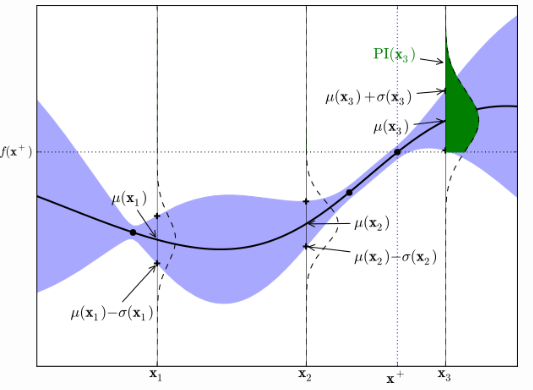

- Acquisiton Function : surrogate model이 목적함수 (우리가 찾고자 하는 함수)에 대하여 실제 데이터를 기반으로 다음 번 조사할 x 값을 확률적으로 계산하여 추천해주는 함수이다.
- Exploitation : 현재까지 조사된 값들의 근방으로 다시 조사를 하는 것이다. 착취를 말한다.
- Exploration : 현재까지 조사된 값들의 근방으로 조사를 하지 않고, 불확실성이 제일 높은 구간을 조사한다. 탐험을 말한다. 

In [20]:
from optuna.integration import SkoptSampler

sampler=SkoptSampler(skopt_kwargs={'base_estimator':'RF', 'base_estimator':'ET', 'n_random_starts': 0, 'acq_func':'EI', 'acq_func_kwargs': {'xi':0.01}})

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(run, n_trials=20)

[I 2021-08-31 16:12:31,283] A new study created in memory with name: no-name-0c65a122-2fe9-4044-b5b3-a6750878fefa


[16:12:33] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.55199
[1000]	validation_0-rmse:0.72099
[2000]	validation_0-rmse:0.71985
[2409]	validation_0-rmse:0.71985


[I 2021-08-31 16:12:45,424] Trial 0 finished with value: 0.7198114610412187 and parameters: {'learning_rate': 0.029632202305887506, 'reg_lambda': 0.0009384679227733366, 'reg_alpha': 0.0002504190753541419, 'subsample': 0.8777952948083436, 'colsample_bytree': 0.8723339564269927, 'max_depth': 5}. Best is trial 0 with value: 0.7198114610412187.


[16:12:48] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.60572
[1000]	validation_0-rmse:0.71921
[2000]	validation_0-rmse:0.71822
[2233]	validation_0-rmse:0.71826


[I 2021-08-31 16:13:09,465] Trial 1 finished with value: 0.718174112282232 and parameters: {'learning_rate': 0.022599315314533765, 'reg_lambda': 0.08482095696756328, 'reg_alpha': 2.462431724392401, 'subsample': 0.822679675173786, 'colsample_bytree': 0.1483192239511922, 'max_depth': 7}. Best is trial 1 with value: 0.718174112282232.


[16:13:11] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.39364
[1000]	validation_0-rmse:0.72097
[1952]	validation_0-rmse:0.72018


[I 2021-08-31 16:13:16,173] Trial 2 finished with value: 0.7200514165312517 and parameters: {'learning_rate': 0.18008479762695956, 'reg_lambda': 5.035073927900096e-08, 'reg_alpha': 7.722576266827834, 'subsample': 0.23443742392462943, 'colsample_bytree': 0.685226912045053, 'max_depth': 2}. Best is trial 1 with value: 0.718174112282232.


[16:13:18] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.45926
[342]	validation_0-rmse:0.74113


[I 2021-08-31 16:13:34,578] Trial 3 finished with value: 0.7278125006017132 and parameters: {'learning_rate': 0.17180628017033983, 'reg_lambda': 0.02420961760195006, 'reg_alpha': 0.9208476413412556, 'subsample': 0.971270356852007, 'colsample_bytree': 0.4122470319468645, 'max_depth': 10}. Best is trial 1 with value: 0.718174112282232.


[16:13:36] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.14106
[1000]	validation_0-rmse:0.71877
[1934]	validation_0-rmse:0.71874


[I 2021-08-31 16:13:43,104] Trial 4 finished with value: 0.718494732022414 and parameters: {'learning_rate': 0.0829372540380671, 'reg_lambda': 9.70569035053972, 'reg_alpha': 0.0008355239462730327, 'subsample': 0.44883241585814515, 'colsample_bytree': 0.10282093735386452, 'max_depth': 4}. Best is trial 1 with value: 0.718174112282232.


[16:13:45] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.44278
[655]	validation_0-rmse:0.72436


[I 2021-08-31 16:13:55,623] Trial 5 finished with value: 0.7231418514521825 and parameters: {'learning_rate': 0.04381025365336831, 'reg_lambda': 1.5668070496236324e-05, 'reg_alpha': 1.1060169252617319e-06, 'subsample': 0.3891343350253479, 'colsample_bytree': 0.439912044297188, 'max_depth': 8}. Best is trial 1 with value: 0.718174112282232.


[16:13:58] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.46906
[341]	validation_0-rmse:0.74436


[I 2021-08-31 16:14:14,423] Trial 6 finished with value: 0.7289084219116021 and parameters: {'learning_rate': 0.17057381632986549, 'reg_lambda': 3.382863709686013e-07, 'reg_alpha': 1.5119819469951765, 'subsample': 0.9091291934883516, 'colsample_bytree': 0.7343483594386537, 'max_depth': 10}. Best is trial 1 with value: 0.718174112282232.


[16:14:17] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.57708
[1000]	validation_0-rmse:0.71856
[1312]	validation_0-rmse:0.71863


[I 2021-08-31 16:14:21,238] Trial 7 finished with value: 0.7185277224450666 and parameters: {'learning_rate': 0.15621192368401715, 'reg_lambda': 0.0007252679578817088, 'reg_alpha': 2.607165509856465, 'subsample': 0.9039201609416152, 'colsample_bytree': 0.2148971913478483, 'max_depth': 3}. Best is trial 1 with value: 0.718174112282232.


[16:14:23] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.28435
[449]	validation_0-rmse:0.72501


[I 2021-08-31 16:14:28,100] Trial 8 finished with value: 0.7210807108717558 and parameters: {'learning_rate': 0.19428026424213257, 'reg_lambda': 1.292001556758189, 'reg_alpha': 0.10560318310919094, 'subsample': 0.9498175018171335, 'colsample_bytree': 0.13914159387968167, 'max_depth': 7}. Best is trial 1 with value: 0.718174112282232.


[16:14:30] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.54369
[904]	validation_0-rmse:0.71851


[I 2021-08-31 16:14:37,235] Trial 9 finished with value: 0.7182971314734719 and parameters: {'learning_rate': 0.16056641909821087, 'reg_lambda': 0.2894755944705531, 'reg_alpha': 51.76063768520257, 'subsample': 0.7805499944153579, 'colsample_bytree': 0.11702606729601339, 'max_depth': 8}. Best is trial 1 with value: 0.718174112282232.


[16:14:39] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.90263
[509]	validation_0-rmse:0.72602


[I 2021-08-31 16:14:52,327] Trial 10 finished with value: 0.7221816283785776 and parameters: {'learning_rate': 0.11389944907902168, 'reg_lambda': 0.007174365888678618, 'reg_alpha': 0.8434953824526927, 'subsample': 0.9243563844537421, 'colsample_bytree': 0.14471637786474548, 'max_depth': 9}. Best is trial 1 with value: 0.718174112282232.


[16:14:55] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.66939
[413]	validation_0-rmse:0.73310


[I 2021-08-31 16:15:04,035] Trial 11 finished with value: 0.725368639190567 and parameters: {'learning_rate': 0.1442613105874519, 'reg_lambda': 11.434965288310936, 'reg_alpha': 16.706906460361655, 'subsample': 0.24957591797420484, 'colsample_bytree': 0.2954226059328186, 'max_depth': 10}. Best is trial 1 with value: 0.718174112282232.


[16:15:06] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.04749
[350]	validation_0-rmse:0.74137


[I 2021-08-31 16:15:12,327] Trial 12 finished with value: 0.7261394437615329 and parameters: {'learning_rate': 0.22559720451330662, 'reg_lambda': 0.05750417758328354, 'reg_alpha': 3.0068432520814032, 'subsample': 0.8209997953456957, 'colsample_bytree': 0.7184074564188222, 'max_depth': 8}. Best is trial 1 with value: 0.718174112282232.


[16:15:14] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.46196
[841]	validation_0-rmse:0.72228


[I 2021-08-31 16:15:49,061] Trial 13 finished with value: 0.7213118348913394 and parameters: {'learning_rate': 0.041260730201594494, 'reg_lambda': 0.9495722983465674, 'reg_alpha': 5.755493292455484e-08, 'subsample': 0.7714007181253079, 'colsample_bytree': 0.12690537083648973, 'max_depth': 10}. Best is trial 1 with value: 0.718174112282232.


[16:15:51] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.25685
[575]	validation_0-rmse:0.72116


[I 2021-08-31 16:15:56,116] Trial 14 finished with value: 0.7202475814619403 and parameters: {'learning_rate': 0.19786240353642937, 'reg_lambda': 0.0006448004269413652, 'reg_alpha': 76.9289609209557, 'subsample': 0.9269702015972504, 'colsample_bytree': 0.4280020973531581, 'max_depth': 7}. Best is trial 1 with value: 0.718174112282232.


[16:15:58] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:7.31113
[630]	validation_0-rmse:0.72344


[I 2021-08-31 16:16:17,995] Trial 15 finished with value: 0.7222196865207814 and parameters: {'learning_rate': 0.06084379643235182, 'reg_lambda': 0.0021947111733893357, 'reg_alpha': 3.0658172228565537, 'subsample': 0.44774373578291693, 'colsample_bytree': 0.12500969946647142, 'max_depth': 10}. Best is trial 1 with value: 0.718174112282232.


[16:16:20] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.60979
[1000]	validation_0-rmse:0.72020
[2000]	validation_0-rmse:0.71863
[2781]	validation_0-rmse:0.71852


[I 2021-08-31 16:16:27,224] Trial 16 finished with value: 0.7184741605487354 and parameters: {'learning_rate': 0.15230463212049017, 'reg_lambda': 8.113422084940065e-06, 'reg_alpha': 1.735761728569635, 'subsample': 0.809334031320624, 'colsample_bytree': 0.9390543561692669, 'max_depth': 2}. Best is trial 1 with value: 0.718174112282232.


[16:16:29] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.45455
[411]	validation_0-rmse:0.73069


[I 2021-08-31 16:16:32,653] Trial 17 finished with value: 0.7255076686658477 and parameters: {'learning_rate': 0.17253493572368925, 'reg_lambda': 0.13461715570328295, 'reg_alpha': 0.13036472880799263, 'subsample': 0.5805837217459958, 'colsample_bytree': 0.9621510187079894, 'max_depth': 6}. Best is trial 1 with value: 0.718174112282232.


[16:16:35] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.18294
[503]	validation_0-rmse:0.72366


[I 2021-08-31 16:16:37,693] Trial 18 finished with value: 0.7218586410890091 and parameters: {'learning_rate': 0.2079684484386115, 'reg_lambda': 0.00019139552347218936, 'reg_alpha': 6.422200592183879, 'subsample': 0.8343923877195998, 'colsample_bytree': 0.9742902531477641, 'max_depth': 5}. Best is trial 1 with value: 0.718174112282232.


[16:16:40] WARNING: ../src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-rmse:6.56900
[382]	validation_0-rmse:0.73269


[I 2021-08-31 16:16:50,704] Trial 19 finished with value: 0.7248959332333272 and parameters: {'learning_rate': 0.15726084410021343, 'reg_lambda': 0.20261779019585147, 'reg_alpha': 0.21207440825750984, 'subsample': 0.9655977397221323, 'colsample_bytree': 0.1915762193111105, 'max_depth': 9}. Best is trial 1 with value: 0.718174112282232.


In [21]:
study.best_params

{'learning_rate': 0.022599315314533765,
 'reg_lambda': 0.08482095696756328,
 'reg_alpha': 2.462431724392401,
 'subsample': 0.822679675173786,
 'colsample_bytree': 0.1483192239511922,
 'max_depth': 7}

In [22]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-0.7231495639795043

위의 파라미터를 설정한 경우 같은 횟수 내 좋은 파라미터를 찾지는 못했다. 하지만 횟수를 높인다면 다른 방법들 보다 더 빨리 좋은 성능의 모델을 찾을 수 있을 것이다.